In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import stim
print(stim.__version__)

import matplotlib.pyplot as plt
import numpy as np
import math

from ldpc import bp_decoder, bposd_decoder
import time
from src.utils import rank
from src.codes_q import create_bivariate_QC_codes, create_circulant_matrix
from src.build_circuit import build_circuit, dem_to_check_matrices


# [[72,12,6]]
# code, A_list, B_list = create_bivariate_QC_codes(6, 6, [3], [1,2], [1,2], [3])

# [[90,8,10]]
# code, A_list, B_list = create_bivariate_QC_codes(15, 3, [9], [1,2], [2,7], [0])

# [[108,8,10]]
# code, A_list, B_list = create_bivariate_QC_codes(9, 6, [3], [1,2], [1,2], [3])

# [[144,12,12]]
code, A_list, B_list = create_bivariate_QC_codes(12, 6, [3], [1,2], [1,2], [3])

# [[288,12,18]]
# code, A_list, B_list = create_bivariate_QC_codes(12, 12, [3], [2,7], [1,2], [3])

# [[360,12,<=24]]
# code, A_list, B_list = create_bivariate_QC_codes(30, 6, [9], [1,2], [25,26], [3])

# [[756,16,<=34]]
# code, A_list, B_list = create_bivariate_QC_codes(21,18, [3], [10,17], [3,19], [5])

print(code.name)
n = code.N
n_half = n//2
z_basis = True

1.13.dev1701377008
IBM_n144_k12


In [17]:
def sliding_window_decoder(p=0.003, num_repeat=12, num_shots=10000, max_iter=200, W=2, F=1, z_basis=True, noisy_prior=None, method=0, plot=False):
    circuit = build_circuit(code, A_list, B_list, p, num_repeat, z_basis=z_basis)
    dem = circuit.detector_error_model()
    chk, obs, priors, col_dict = dem_to_check_matrices(dem, return_col_dict=True)
    num_row, num_col = chk.shape

    lower_bounds = []
    upper_bounds = []
    i = 0
    while i < num_row:
        lower_bounds.append(i)
        upper_bounds.append(i+n_half)
        if i+n > num_row:
            break
        lower_bounds.append(i)
        upper_bounds.append(i+n)
        i += n_half

    region_dict = {}
    for i, (l,u) in enumerate(zip(lower_bounds, upper_bounds)):
        region_dict[(l,u)] = i

    region_cols = [[] for _ in range(len(region_dict))]

    for i in range(num_col):
        nnz_col = np.nonzero(chk[:,i])[0]
        l = nnz_col.min() // n_half * n_half
        u = (nnz_col.max() // n_half + 1) * n_half
        region_cols[region_dict[(l,u)]].append(i)  

    chk = np.concatenate([chk[:,col].toarray() for col in region_cols], axis=1)
    obs = np.concatenate([obs[:,col].toarray() for col in region_cols], axis=1)
    priors = np.concatenate([priors[col] for col in region_cols])

    anchors = []
    j = 0
    for i in range(num_col):
        nnz_col = np.nonzero(chk[:,i])[0]
        if (nnz_col.min() >= j):
            anchors.append((j, i))
            j += n_half
    anchors.append((num_row, num_col))
    
    if noisy_prior is None and method != 0:
        b = anchors[W]
        c = anchors[W-1]
        if method == 1:
            c = (c[0], c[1]+n_half*3) if z_basis else (c[0], c[1]+n)
#             c = (c[0], c[1]+n_half*3) # try also this for x basis
        noisy_prior = np.sum(chk[c[0]:b[0],c[1]:b[1]] * priors[c[1]:b[1]], axis=1)
        print("prior for noisy syndrome", noisy_prior[0])

    if method != 0:
        noisy_syndrome_priors = np.ones(n_half) * noisy_prior
    
    num_win = math.ceil((len(anchors)-W+F-1) / F)
    chk_submats = []
    prior_subvecs = []
    if plot:
        fig, ax = plt.subplots(num_win, 1)
    top_left = 0
    i = 0
    for i in range(num_win):
        a = anchors[top_left]
        bottom_right = min(top_left + W, len(anchors)-1)
        b = anchors[bottom_right]

        if i != num_win-1 and method != 0: # not the last round
            c = anchors[top_left + W - 1]
            if method == 1:
                c = (c[0], c[1]+n_half*3) if z_basis else (c[0], c[1]+n)
#                 c = (c[0], c[1]+n_half*3) # try also this for x basis
            noisy_syndrome = np.zeros((n_half*W,n_half))
            noisy_syndrome[-n_half:,:] = np.eye(n_half)# * noisy_syndrome_prior
            mat = chk[a[0]:b[0],a[1]:c[1]]
            mat = np.hstack((mat, noisy_syndrome))
            prior = priors[a[1]:c[1]]
            prior = np.concatenate((prior, noisy_syndrome_priors))
        else: # method==0 or last round
            mat = chk[a[0]:b[0],a[1]:b[1]]
            prior = priors[a[1]:b[1]]
        chk_submats.append(mat)
        prior_subvecs.append(prior)
        if plot:
            ax[i].imshow(mat, cmap="gist_yarg")
        top_left += F

    start_time = time.perf_counter()
    dem_sampler: stim.CompiledDemSampler = dem.compile_sampler()
    det_data, obs_data, err_data = dem_sampler.sample(shots=num_shots, return_errors=False, bit_packed=False)
    end_time = time.perf_counter()
    print(f"Stim: noise sampling for {num_shots} shots, elapsed time:", end_time-start_time)


    total_e_hat = np.zeros((num_shots,num_col))
    new_det_data = det_data.copy()
    start_time = time.perf_counter()
    top_left = 0
    for i in range(num_win):
        mat = chk_submats[i]
        prior = prior_subvecs[i]
        a = anchors[top_left]
        bottom_right = min(top_left + W, len(anchors)-1)
        b = anchors[bottom_right]
        c = anchors[top_left+F] # commit region bottom right
        bpd = bposd_decoder(
            mat, # the parity check matrix
            error_rate=p, # does not matter because channel_probs is assigned
            channel_probs=prior, # assign error_rate to each qubit. This will override "error_rate" input variable
            max_iter=max_iter, # the maximum number of iterations for BP)
            bp_method="minimum_sum_log",
            ms_scaling_factor=1.0, # min sum scaling factor. If set to zero the variable scaling factor method is used
            osd_method="osd_cs",
            osd_order=10,
            input_vector_type="syndrome", # "received_vector"
        )

        num_flag_err = 0

        detector_win = new_det_data[:,a[0]:b[0]]
        for j in range(num_shots):
            e_hat = bpd.decode(detector_win[j])
            is_flagged = ((mat @ e_hat + detector_win[j]) % 2).any()
            num_flag_err += is_flagged
            if i == num_win-1: # last window
                total_e_hat[j][a[1]:b[1]] = e_hat
            else:
                total_e_hat[j][a[1]:c[1]] = e_hat[:c[1]-a[1]]
          

        print(f"Window {i}, flagged Errors: {num_flag_err}/{num_shots}")

        new_det_data = (det_data + total_e_hat @ chk.T) % 2
        top_left += F

    end_time = time.perf_counter()
    print("Elapsed time:", end_time-start_time)    

    flagged_err = ((det_data + total_e_hat @ chk.T) % 2).any(axis=1)
    num_flagged_err = flagged_err.astype(int).sum()
    print(f"Overall Flagged Errors: {num_flagged_err}/{num_shots}")
    logical_err = ((obs_data + total_e_hat @ obs.T) % 2).any(axis=1)
    num_err = np.logical_or(flagged_err, logical_err).astype(int).sum()
    print(f"Logical Errors: {num_err}/{num_shots}")
    p_l = num_err / num_shots
    p_l_per_round = 1-(1-p_l) ** (1/num_repeat)
    # may also use ** (1/(num_repeat-1))
    # because the first round is for encoding, the next (num_repeat-1) rounds are syndrome measurements rounds
    print("logical error per round:", p_l_per_round)

prior for noisy syndrome 0.036622121785736664
Stim: noise sampling for 10000 shots, elapsed time: 0.018339088186621666
Window 2, flagged Errors: 0/10000
Window 3, flagged Errors: 0/10000
Window 4, flagged Errors: 0/10000
Window 5, flagged Errors: 0/10000
Window 6, flagged Errors: 0/10000
Window 7, flagged Errors: 0/10000
Window 8, flagged Errors: 0/10000
Window 9, flagged Errors: 0/10000
Window 10, flagged Errors: 0/10000
Elapsed time: 405.59435011446476
Overall Flagged Errors: 0/10000
Logical Errors: 242/10000
logical error per round: 0.002039386918861963


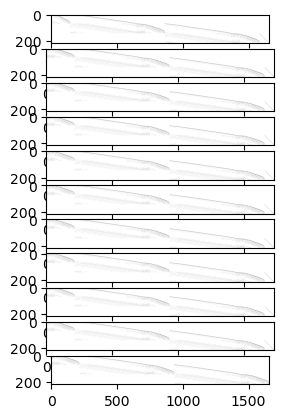

In [20]:
sliding_window_decoder(p=0.004, num_repeat=12, W=3, F=1, num_shots=10000, max_iter=200, method=1, z_basis=True, plot=True)


prior for noisy syndrome 0.036622121785736664
Stim: noise sampling for 10000 shots, elapsed time: 0.019210332073271275
Window 0, flagged Errors: 0/10000
Window 1, flagged Errors: 0/10000
Window 2, flagged Errors: 0/10000
Window 3, flagged Errors: 0/10000
Window 4, flagged Errors: 0/10000
Window 5, flagged Errors: 0/10000
Window 6, flagged Errors: 0/10000
Window 7, flagged Errors: 0/10000
Window 8, flagged Errors: 0/10000
Window 9, flagged Errors: 0/10000
Elapsed time: 671.4120974745601
Overall Flagged Errors: 0/10000
Logical Errors: 131/10000
logical error per round: 0.0010982766026512714


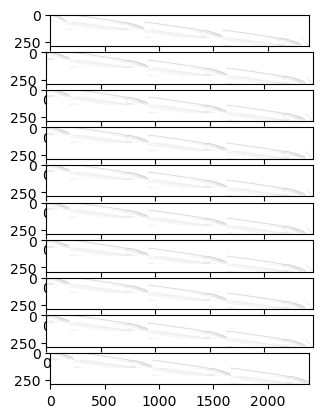

In [21]:
sliding_window_decoder(p=0.004, num_repeat=12, W=4, F=1, num_shots=10000, max_iter=200, method=1, z_basis=True, plot=True)


prior for noisy syndrome 0.036622121785736664
Stim: noise sampling for 10000 shots, elapsed time: 0.0224069906398654
Window 0, flagged Errors: 0/10000
Window 1, flagged Errors: 0/10000
Window 2, flagged Errors: 0/10000
Window 3, flagged Errors: 0/10000
Window 4, flagged Errors: 0/10000
Window 5, flagged Errors: 0/10000
Window 6, flagged Errors: 0/10000
Window 7, flagged Errors: 0/10000
Window 8, flagged Errors: 0/10000
Elapsed time: 986.8894162587821
Overall Flagged Errors: 0/10000
Logical Errors: 108/10000
logical error per round: 0.0009044859836397912


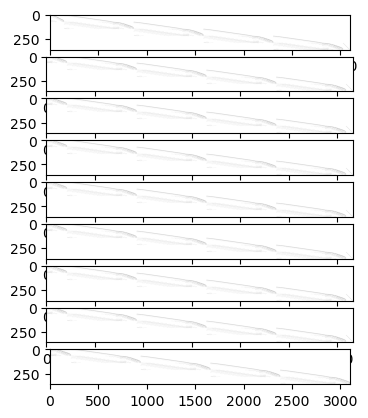

In [22]:
sliding_window_decoder(p=0.004, num_repeat=12, W=5, F=1, num_shots=10000, max_iter=200, method=1, z_basis=True, plot=True)


prior for noisy syndrome 0.05900506726184526
Stim: noise sampling for 10000 shots, elapsed time: 0.018310649320483208
Window 0, flagged Errors: 0/10000
Window 1, flagged Errors: 0/10000
Window 2, flagged Errors: 0/10000
Window 3, flagged Errors: 0/10000
Window 4, flagged Errors: 0/10000
Elapsed time: 487.22291984036565
Overall Flagged Errors: 0/10000
Logical Errors: 140/10000
logical error per round: 0.0011742204280067448


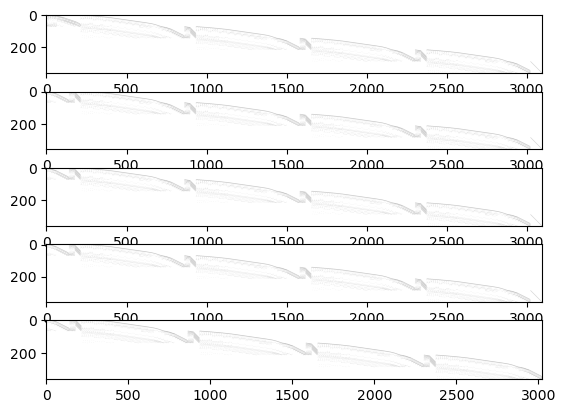

In [30]:
sliding_window_decoder(p=0.004, num_repeat=12, W=5, F=2, num_shots=10000, max_iter=200, method=1, z_basis=False, plot=True)


In [23]:
sliding_window_decoder(p=0.003, num_repeat=12, W=3, F=1, num_shots=100000, max_iter=200, method=1, z_basis=True)


prior for noisy syndrome 0.027499817877069083
Stim: noise sampling for 100000 shots, elapsed time: 0.20823763776570559
Window 0, flagged Errors: 0/100000
Window 1, flagged Errors: 0/100000
Window 2, flagged Errors: 0/100000
Window 3, flagged Errors: 0/100000
Window 4, flagged Errors: 0/100000
Window 5, flagged Errors: 0/100000
Window 6, flagged Errors: 0/100000
Window 7, flagged Errors: 0/100000
Window 8, flagged Errors: 0/100000
Window 9, flagged Errors: 0/100000
Window 10, flagged Errors: 0/100000
Elapsed time: 2344.9018181683496
Overall Flagged Errors: 0/100000
Logical Errors: 351/100000
logical error per round: 0.00029297161731256516


In [24]:
sliding_window_decoder(p=0.003, num_repeat=12, W=4, F=1, num_shots=100000, max_iter=200, method=1, z_basis=True)


prior for noisy syndrome 0.027499817877069083
Stim: noise sampling for 100000 shots, elapsed time: 0.20947750099003315
Window 0, flagged Errors: 0/100000
Window 1, flagged Errors: 0/100000
Window 2, flagged Errors: 0/100000
Window 3, flagged Errors: 0/100000
Window 4, flagged Errors: 0/100000
Window 5, flagged Errors: 0/100000
Window 6, flagged Errors: 0/100000
Window 7, flagged Errors: 0/100000
Window 8, flagged Errors: 0/100000
Window 9, flagged Errors: 0/100000
Elapsed time: 3724.0366667155176
Overall Flagged Errors: 0/100000
Logical Errors: 159/100000
logical error per round: 0.00013259665757714423


In [25]:
sliding_window_decoder(p=0.003, num_repeat=12, W=5, F=1, num_shots=100000, max_iter=200, method=1, z_basis=True)


prior for noisy syndrome 0.027499817877069083
Stim: noise sampling for 100000 shots, elapsed time: 0.22321351245045662
Window 0, flagged Errors: 0/100000
Window 1, flagged Errors: 0/100000
Window 2, flagged Errors: 0/100000
Window 3, flagged Errors: 0/100000
Window 4, flagged Errors: 0/100000
Window 5, flagged Errors: 0/100000
Window 6, flagged Errors: 0/100000
Window 7, flagged Errors: 0/100000
Window 8, flagged Errors: 0/100000
Elapsed time: 5432.898962600157
Overall Flagged Errors: 0/100000
Logical Errors: 119/100000
logical error per round: 9.922079497637348e-05
